## Tutorial 1 


Vector Addition
=================
In this tutorial, you will write a simple vector addition using Triton and learn about:

- The basic programming model of Triton
- The `triton.jit` decorator, which is used to define Triton kernels.
- The best practices for validating and benchmarking your custom ops against native reference implementations


In [13]:
import torch
import triton.language as tl
import triton


In [14]:
@triton.jit
def _add(
    X,  # *pointer* to input vector 1
    Y,  # *pointer * to input vector 2
    Z,  # *pointer* to output vector
    N,  # Size of the vector
    **meta  #Optional meta parameters for the kernel 
            # In meta, block size and compile time constants etc parameters
):
    #Roughly the start of the block
    pid = tl.program_id(0)
    
    #We dont worry about threads here. We are writing program for
    #whole block for now

    # Create offset for the block of pointers to be processed 
    # by the program instance
    #Read all the block of pointers
    offsets = pid * meta['BLOCK'] + tl.arange(0, meta['BLOCK'])

    #Create a mask to guard memory operations against 
    #out-of-bound accesses

    #mask defines the shape. It defines what to load and what to
    #leave undefined
    mask = offsets < N

    #Load x 
    #scale + arange -> yields block of pointers
    load_x_ptrs = X + offsets
    load_y_ptrs = Y + offsets

    x = tl.load(load_x_ptrs, mask = mask)     # x <- tensor of data
    y = tl.load(load_y_ptrs, mask = mask)

    #Write x + y
    z = x + y
    tl.store(Z + offsets, z)




- Let's also declare a helper function to (1) allocate the `z` tensor
and (2) enqueue the above kernel with appropriate grid/block sizes.


In [15]:
def add(x, y):
    z = torch.empty_like(x)
    N = z.shape[0]
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int]
    grid = lambda meta: (triton.cdiv(N, meta['BLOCK']), )
    # NOTE:
    #  - each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be index with a launch grid to obtain a callable GPU kernel
    #  - don't forget to pass meta-parameters as keywords arguments
    _add[grid](x, y, z, N, BLOCK=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return z



- We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:


In [16]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
za = x + y
zb = add(x, y)
print(za)
print(zb)
print(f'The maximum difference between torch and triton is ' f'{torch.max(torch.abs(za - zb))}')


tensor([1.3713, 1.3076, 0.4940,  ..., 1.1495, 0.9265, 1.1323], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 1.1495, 0.9265, 1.1323], device='cuda:0')
The maximum difference between torch and triton is 0.0



# Benchmark
# -----------
 - We can now benchmark our custom op on vectors of increasing sizes to get a sense of how it does relative to PyTorch.
 - To make things easier, Triton has a set of built-in utilities that allow us to concisely plot the performance of your custom ops
 - for different problem sizes.


In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # argument names to use as an x-axis for the plot
        x_vals=[2**i for i in range(12, 28, 1)],  # different possible values for `x_name`
        x_log=True,  # x axis is logarithmic
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg`
        line_names=["Triton", "Torch"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="vector-add-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={}  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y))
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)




 - We can now run the decorated function above. Pass `print_data=True` to see the performance number, `show_plots=True` to plot them, and/or
 - save_path='/path/to/results/' to save them to disk along with raw CSV data

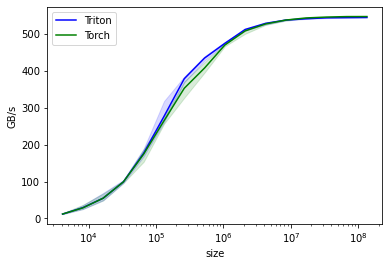

vector-add-performance:
           size      Triton       Torch
0        4096.0   11.906977   12.000000
1        8192.0   29.257143   28.710280
2       16384.0   54.857142   54.857142
3       32768.0   99.096776   99.096776
4       65536.0  176.805760  174.297876
5      131072.0  276.134828  264.258058
6      262144.0  378.092307  352.344086
7      524288.0  434.013258  407.055892
8     1048576.0  473.754231  469.231516
9     2097152.0  511.334216  507.375469
10    4194304.0  527.629634  526.041480
11    8388608.0  536.722047  536.722047
12   16777216.0  540.224639  542.460410
13   33554432.0  542.764627  544.832722
14   67108864.0  543.362286  546.121493
15  134217728.0  543.849593  546.240016


In [19]:
benchmark.run(print_data=True, show_plots=True)